In [1]:
from cnn_helper import *
from text_detection import *
from character_extraction import *

import tensorflow as tf
import cv2

2026-01-16 16:16:08.714499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 16:16:08.723973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768576568.734447   60900 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768576568.738029   60900 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768576568.747949   60900 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

def detect_characters(binary_image, boxes):
    result = {}
    for i, box in enumerate(boxes):
        result[i] = {}
        box = box.astype(int)
        
        x, y, w, h = cv2.boundingRect(box)
        result[i]["box_coords"] = (x, y, w, h)

        cropped = binary_image[
            y: y + h,
            x: x + w
        ]

        all_characters, labels = find_characters(cropped)

        total_image_area = cropped.shape[0] * cropped.shape[1]
        min_area_threshold = total_image_area/100
        max_area_treshold = total_image_area
        filtered_characters = filter_characters(all_characters, min_area_threshold, max_area_treshold)
        sorted_characters = sort_characters_left_to_right(filtered_characters)
        #visualize_character_detection(cropped, all_characters, sorted_characters)
        result[i]["characters"] = sorted_characters
        
    return result


def add_labels(grayscale, image, a, char_model):
    result_img = image.copy()
    result_string = ''
    for box in a:
        box_x, box_y, box_w, box_h = a[box]['box_coords']

        pad_x = int(box_x * 0.1)  # 10% horizontal padding
        pad_y = int(box_h * 0.1)  # 10% vertical padding

        box_img = grayscale[
            box_y: box_y + box_h,
            box_x: box_x + box_w
        ]
        #display_array_as_image(box_img)

        for char in a[box]['characters']:
            char_x, char_y, char_w, char_h = char["bbox"]
            label = char["label"]
            char_img = box_img[char_y:char_y+char_h, char_x:char_x+char_w]

            char_img = pad_to_square(char_img)
            
            char_img = preprocess_image_for_cnn(char_img, emnist)
            #display_array_as_image(char_img)
            
            prediction_proba = char_model.predict(char_img, verbose=0)
            predicted_class_id = np.argmax(prediction_proba[0])
            predicted_char = class_to_char(predicted_class_id, alpha)
            confidence = np.max(prediction_proba[0])
            
            #print(predicted_char, confidence)

            result_string += predicted_char
            #cv2.putText(result_img, str(predicted_char), (box_x + char_x + char_w, box_y+char_y-5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
            cv2.rectangle(result_img, (box_x + char_x, box_y + char_y), (box_x + char_x + char_w, box_y + char_y + char_h), (255, 255, 255), -1)
            cv2.putText(result_img, str(predicted_char), (box_x + char_x, box_y + char_y + char_h - 5), cv2.FONT_HERSHEY_SIMPLEX, char_h / 30, (0, 255, 0), 2)
    
    # Save the image
    print("Saving the image")
    cv2.imwrite("labeled_image.jpg", result_img)
    return result_string

In [3]:
def extract_images(image_path, craft_model, cnn_model):
    
    original, grayscale = load_and_convert_to_grayscale(image_path)
    denoised_image = denoise_image(grayscale)
    binary_image = convert_to_binary(denoised_image)
    display_conversion_steps(original, grayscale, denoised_image, binary_image)
    
    print("extracting features")
    y, feature = extract_features(binary_image, craft_model)
    
    print("boxes")
    boxes = get_boxes(y)
    sorted_boxes = sort_boxes(boxes)
    print("visualizing")
    #visualize_text_detection(binary_image, boxes)

    b = detect_characters(binary_image, sorted_boxes)

    string = add_labels(grayscale, original, b, cnn_model)

    return string


In [4]:
global alpha, alphanum, emnist
alpha, alphanum, emnist = False, False, True

name1 = "alpha_test_cnn.keras" # 93.35
name2 = "alpha_test_50_cnn.keras"
name3 = "alpha_mnist_test_50_cnn.keras"
name4 = "alpha_mnist_attention_cnn.keras"
name5 = "emnist.keras"



cnn_model = tf.keras.models.load_model('../models/cnn/' + name5)


2026-01-16 16:16:10.331190: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
craft_model = load_craft()

In [6]:
# REMOVE PADDING FROM TEXT BOX, EXTRACT ORIGINAL BOX, ALIGN ORIGINAL BOX, BLACK BORDER????????? 

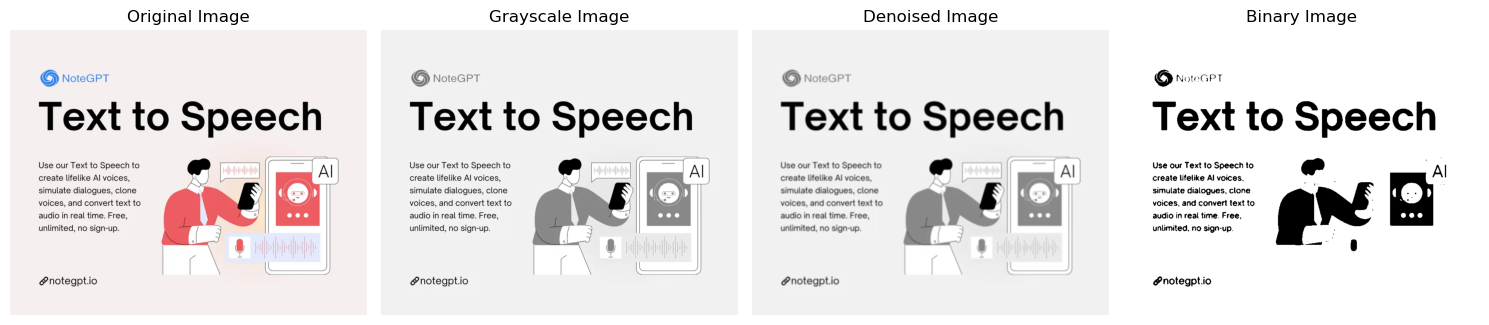

extracting features
boxes
visualizing


In [9]:
a = extract_images("../test_images/test31.jpg", craft_model, cnn_model)

In [33]:
a

'11TeXtt0SPeeChUSeOUrTeXtOSMhCreate11Fe11KeA1VOreSS1MU1ated1a1QWSC10neVO1CeSandCOnVeHteXtaUd1O11nrea1t1MFreUn11M1tedn0S1gnUPn0te9Pt1L10'